In [1]:
# === TP2 - PARTE 1 (Base limpia SOLO INDIVIDUOS + merge con HOGARES) =========
# Mantener comentarios/anotaciones del equipo

import pandas as pd
import numpy as np
import os

# Rutas de INDIVIDUALES (TP1)  <-- TUS RUTAS
path_ind_2005 = r"C:\Users\gasto\Desktop\Taller de Programación\TP1\Individual_t105.dta"
path_ind_2025 = r"C:\Users\gasto\Desktop\Taller de Programación\TP1\usu_individual_T125.xlsx"

# Rutas de HOGARES (para traer IX_TOT)
path_hog_2005 = r"C:\Users\gasto\Desktop\Taller de Programación\TP1\Hogar_t105.dta"
path_hog_2025 = r"C:\Users\gasto\Desktop\Taller de Programación\TP1\usu_hogar_T125.xlsx"

# Carpeta de salida del TP2
out_dir = r"C:\Users\gasto\Desktop\Taller de Programación\TP2"
os.makedirs(out_dir, exist_ok=True)

print("OK: rutas cargadas y carpeta de salida creada:", out_dir)

OK: rutas cargadas y carpeta de salida creada: C:\Users\gasto\Desktop\Taller de Programación\TP2


In [2]:
# --- Cargar IND (2005 .dta / 2025 .xlsx) y normalizar nombres ----------------
ind_2005 = pd.read_stata(path_ind_2005)
ind_2025 = pd.read_excel(path_ind_2025, engine="openpyxl")

for df in (ind_2005, ind_2025):
    df.columns = df.columns.str.upper().str.strip()

print("IND 2005:", ind_2005.shape, "| IND 2025:", ind_2025.shape)

IND 2005: (47030, 176) | IND 2025: (45425, 235)


In [3]:
# --- Filtrar PATAGONIA y agregar ANIO/TRIMESTRE --------------------------------
def filtrar_patagonia(df, anio):
    if "REGION" not in df.columns:
        raise KeyError("No se encontró la columna REGION en la base de Individuos.")

    # REGION puede ser numérica (44) o string ("Patagónica")
    if pd.api.types.is_numeric_dtype(df["REGION"]):
        mask = df["REGION"].isin([44, 6])  # 44 código moderno; 6 en extractos viejos
        out = df.loc[mask].copy()
    else:
        out = df[df["REGION"].astype(str).str.upper().str.contains("PATAG", na=False)].copy()

    out["ANIO"] = int(anio)
    out["TRIMESTRE"] = 1
    return out

ind_2005_r = filtrar_patagonia(ind_2005, 2005)
ind_2025_r = filtrar_patagonia(ind_2025, 2025)

print("Patagonia IND 2005:", ind_2005_r.shape, "| IND 2025:", ind_2025_r.shape)

Patagonia IND 2005: (3229, 177) | IND 2025: (5359, 236)


In [4]:
# --- Cargar Hogares, normalizar y filtrar Patagonia (para IX_TOT) -------------
hog_2005 = pd.read_stata(path_hog_2005)
hog_2025 = pd.read_excel(path_hog_2025, engine="openpyxl")

for df in (hog_2005, hog_2025):
    df.columns = df.columns.str.upper().str.strip()

def filtrar_hog_patagonia(df, anio):
    if "REGION" not in df.columns:
        raise KeyError("No se encontró REGION en Hogares.")
    if pd.api.types.is_numeric_dtype(df["REGION"]):
        mask = df["REGION"].isin([44, 6])
        out = df.loc[mask].copy()
    else:
        out = df[df["REGION"].astype(str).str.upper().str.contains("PATAG", na=False)].copy()
    out["ANIO"] = int(anio)
    return out

hog_2005_r = filtrar_hog_patagonia(hog_2005, 2005)
hog_2025_r = filtrar_hog_patagonia(hog_2025, 2025)

# Tomar solo claves + IX_TOT (en 2025 a veces viene con distinta capitalización)
col_ix_2025 = "IX_TOT" if "IX_TOT" in hog_2025_r.columns else ("IX_Tot" if "IX_Tot" in hog_2025_r.columns else None)
if col_ix_2025 is None:
    raise KeyError("No se encuentra IX_TOT en Hogares 2025.")

hog_2005_min = hog_2005_r[["CODUSU", "NRO_HOGAR", "ANIO", "IX_TOT"]].copy()
hog_2025_min = hog_2025_r[["CODUSU", "NRO_HOGAR", "ANIO", col_ix_2025]].rename(columns={col_ix_2025:"IX_TOT"}).copy()

hog_union = pd.concat([hog_2005_min, hog_2025_min], ignore_index=True)

# Claves como string para evitar problemas
for d in (hog_union,):
    d["CODUSU"] = d["CODUSU"].astype(str).str.strip()
    d["NRO_HOGAR"] = d["NRO_HOGAR"].astype(str).str.strip()

print("HOG Patagonia unida:", hog_union.shape)
hog_union.head()

HOG Patagonia unida: (3036, 4)


,CODUSU,NRO_HOGAR,ANIO,IX_TOT
0,125814,1.0,2005,5.0
1,125969,1.0,2005,2.0
2,126039,1.0,2005,1.0
3,126757,1.0,2005,5.0
4,127292,1.0,2005,2.0


In [5]:
# --- Unir IND 2005+2025 y traer IX_TOT desde Hogares --------------------------
base_ind = pd.concat([ind_2005_r, ind_2025_r], ignore_index=True)

# Claves como string
for d in (base_ind,):
    d["CODUSU"] = d["CODUSU"].astype(str).str.strip()
    d["NRO_HOGAR"] = d["NRO_HOGAR"].astype(str).str.strip()

base = base_ind.merge(hog_union, on=["CODUSU", "NRO_HOGAR", "ANIO"], how="left")

# Crear MIEMBROS_HOGAR a partir de IX_TOT
base["MIEMBROS_HOGAR"] = pd.to_numeric(base["IX_TOT"], errors="coerce")

print("Base IND + IX_TOT:", base.shape)
base[["CODUSU","NRO_HOGAR","ANIO","REGION","MIEMBROS_HOGAR"]].head()

Base IND + IX_TOT: (8588, 246)


,CODUSU,NRO_HOGAR,ANIO,REGION,MIEMBROS_HOGAR
0,125814,1.0,2005,Patagónica,5.0
1,125814,1.0,2005,Patagónica,5.0
2,125814,1.0,2005,Patagónica,5.0
3,125814,1.0,2005,Patagónica,5.0
4,125814,1.0,2005,Patagónica,5.0


In [6]:
# --- Construir variables para correlación -------------------------------------
# Mapeos de columnas según Individuos (EPH Personas)
# CH06 = edad; NIVEL_ED = nivel educativo; IPCF = ingreso per cápita familiar (proxy)
# Horas trabajadas: PP3E_TOT si existe; si no, intentar sumar PP3E_1... (si están)

# EDAD y EDAD2
base["EDAD"]  = pd.to_numeric(base.get("CH06"), errors="coerce")
base["EDAD2"] = base["EDAD"]**2

# EDUC (proxy): usar NIVEL_ED (ya está en Personas)
base["EDUC"] = pd.to_numeric(base.get("NIVEL_ED"), errors="coerce")

# ITF_OK: indicador simple de ingresos familiares positivos (usamos IPCF>0)
base["IPCF"] = pd.to_numeric(base.get("IPCF"), errors="coerce")
base["ITF_OK"] = (base["IPCF"] > 0).astype("Int64")

# HORAS_TRAB: preferir PP3E_TOT; si no existe, intentar suma PP3E_1..PP3E_TOT
if "PP3E_TOT" in base.columns:
    base["HORAS_TRAB"] = pd.to_numeric(base["PP3E_TOT"], errors="coerce")
else:
    # fallback común: algunas bases traen PP3E_1, PP3E_2, PP3E_3, ... o PP3E_TOT en HOGAR (no usar)
    posibles = [c for c in base.columns if c.startswith("PP3E_") and c != "PP3E_TOT"]
    if posibles:
        base["HORAS_TRAB"] = base[posibles].apply(pd.to_numeric, errors="coerce").sum(axis=1, min_count=1)
    else:
        base["HORAS_TRAB"] = np.nan  # si no hay nada, dejar NaN

# Subset de columnas que vamos a guardar (mantener anotaciones del equipo)
cols_salida = [
    "CODUSU","NRO_HOGAR","ANIO","TRIMESTRE","REGION",
    "CH04","CH06","CH07","CH08","NIVEL_ED","ESTADO","CAT_INAC",
    "IPCF","MIEMBROS_HOGAR","EDAD","EDAD2","EDUC","ITF_OK","HORAS_TRAB"
]

keep = [c for c in cols_salida if c in base.columns]
base_out = base[keep].copy()

print("NaNs por variable (seleccion):")
print(base_out.isna().sum().sort_values(ascending=False).head(12))

print("\nBase final lista para TP2 (preview):", base_out.shape)
base_out.head()

NaNs por variable (seleccion):
EDUC          3229
HORAS_TRAB    3036
EDAD2           57
EDAD            57
ANIO             0
CODUSU           0
NRO_HOGAR        0
TRIMESTRE        0
REGION           0
CH04             0
CH06             0
ESTADO           0
dtype: int64

Base final lista para TP2 (preview): (8588, 19)


,CODUSU,NRO_HOGAR,ANIO,TRIMESTRE,REGION,CH04,CH06,CH07,CH08,NIVEL_ED,ESTADO,CAT_INAC,IPCF,MIEMBROS_HOGAR,EDAD,EDAD2,EDUC,ITF_OK,HORAS_TRAB
0,125814,1.0,2005,1,Patagónica,Varón,46.0,Casado,Obra social (incluye PAMI),Secundaria Incompleta,Ocupado,0.0,480.0,5.0,46.0,2116.0,NaN,1,48.0
1,125814,1.0,2005,1,Patagónica,Mujer,32.0,Casado,Obra social (incluye PAMI),Secundaria Incompleta,Inactivo,Ama de casa,480.0,5.0,32.0,1024.0,NaN,1,0.0
2,125814,1.0,2005,1,Patagónica,Varón,14.0,Soltero,Obra social (incluye PAMI),Primaria Completa,Inactivo,Estudiante,480.0,5.0,14.0,196.0,NaN,1,0.0
3,125814,1.0,2005,1,Patagónica,Varón,9.0,Soltero,Obra social (incluye PAMI),Primaria Incompleta (incluye educación especial),Menor de 10 años,Estudiante,480.0,5.0,9.0,81.0,NaN,1,0.0
4,125814,1.0,2005,1,Patagónica,Mujer,3.0,Soltero,Obra social (incluye PAMI),Sin instrucción,Menor de 10 años,Menor de 6 años,480.0,5.0,3.0,9.0,NaN,1,0.0


In [7]:
# --- Guardar CSV limpio para la PARTE 2 (correlaciones) -----------------------
csv_out = os.path.join(out_dir, "base_tp2_limpia_indiv.csv")
base_out.to_csv(csv_out, index=False, encoding="utf-8")
print("Base guardada en:", csv_out)

Base guardada en: C:\Users\gasto\Desktop\Taller de Programación\TP2\base_tp2_limpia_indiv.csv


NaNs por variable usada: {'EDAD': 57, 'EDAD2': 57, 'EDUC': 3229, 'ITF_OK': 0, 'MIEMBROS_HOGAR': 0, 'HORAS_TRAB': 3036}


,EDAD,EDAD2,EDUC,ITF_OK,MIEMBROS_HOGAR,HORAS_TRAB
EDAD,1.00,0.96,-0.04,-0.05,-0.40,0.31
EDAD2,0.96,1.00,-0.09,-0.05,-0.38,0.17
EDUC,-0.04,-0.09,1.00,-0.04,-0.09,-0.11
ITF_OK,-0.05,-0.05,-0.04,1.00,0.03,-0.19
MIEMBROS_HOGAR,-0.40,-0.38,-0.09,0.03,1.00,-0.24
HORAS_TRAB,0.31,0.17,-0.11,-0.19,-0.24,1.00


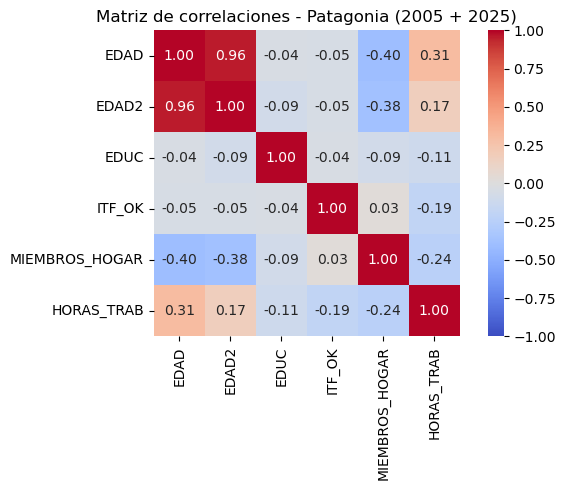

In [8]:
# === TP2 - PARTE 2 (Correlaciones rápidas) ====================================
import matplotlib.pyplot as plt
import seaborn as sns

base2 = pd.read_csv(csv_out)
base2.columns = base2.columns.str.upper().str.strip()

vars_corr = ["EDAD","EDAD2","EDUC","ITF_OK","MIEMBROS_HOGAR","HORAS_TRAB"]
print("NaNs por variable usada:", base2[vars_corr].isna().sum().to_dict())

corr = base2[vars_corr].corr(numeric_only=True).round(2)
display(corr)

plt.figure(figsize=(7,5))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1, square=True)
plt.title("Matriz de correlaciones - Patagonia (2005 + 2025)")
plt.tight_layout()
plt.show()

In [10]:
# === TP2 — Instalación de librerías necesarias (solo correr una vez) ===
import sys
import subprocess

def install_package(package):
    """Instala un paquete usando pip si no está instalado."""
    try:
        __import__(package)
        print(f"✅ {package} ya está instalado.")
    except ImportError:
        print(f"📦 Instalando {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", package])
        print(f"✅ {package} instalado correctamente.\n")

# Lista de paquetes necesarios para PCA y Clustering
packages = [
    "pandas",
    "numpy",
    "matplotlib",
    "seaborn",
    "scikit-learn",
    "scipy",
    "statsmodels"
]

for pkg in packages:
    install_package(pkg)

print("\n🚀 Instalación completa.")


✅ pandas ya está instalado.
✅ numpy ya está instalado.
✅ matplotlib ya está instalado.
✅ seaborn ya está instalado.
📦 Instalando scikit-learn...
✅ scikit-learn instalado correctamente.

✅ scipy ya está instalado.
✅ statsmodels ya está instalado.

🚀 Instalación completa.


In [11]:
# === TP2 — Carga de base limpia y selección de variables para análisis ===
import pandas as pd
import numpy as np

# Ruta a tu base limpia del TP2
path_base = r"C:\Users\gasto\Desktop\Taller de Programación\TP2\base_tp2_limpia_indiv.csv"

base = pd.read_csv(path_base)
base.columns = base.columns.str.upper().str.strip()

# Variables que vamos a usar en PCA/Clustering
vars_pca = ["EDAD", "EDAD2", "EDUC", "ITF_OK", "MIEMBROS_HOGAR", "HORAS_TRAB"]

# Filtrar filas completas para estas variables
X = base[vars_pca].copy()
X = X.replace([np.inf, -np.inf], np.nan).dropna()

print("📊 Observaciones usadas para PCA/Clustering:", X.shape)
display(X.head())

📊 Observaciones usadas para PCA/Clustering: (2323, 6)


,EDAD,EDAD2,EDUC,ITF_OK,MIEMBROS_HOGAR,HORAS_TRAB
3229,48.0,2304.0,6.0,1,3.0,35.0
3232,39.0,1521.0,3.0,1,1.0,48.0
3233,36.0,1296.0,4.0,1,1.0,45.0
3234,30.0,900.0,4.0,1,1.0,48.0
3235,54.0,2916.0,4.0,1,1.0,0.0


In [12]:
# === TP2 — Escalado (StandardScaler) ===
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=True, with_std=True)
X_scaled = scaler.fit_transform(X)

print("✅ Escalado listo. Media aprox.:", np.round(X_scaled.mean(axis=0), 4))
print("Desvíos ≈ 1:", np.round(X_scaled.std(axis=0), 4))

✅ Escalado listo. Media aprox.: [ 0.  0. -0.  0. -0.  0.]
Desvíos ≈ 1: [1. 1. 1. 1. 1. 1.]


In [13]:
# === TP2 — PCA: ajuste y resúmenes ===
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np

# Ajusto PCA sobre variables estandarizadas
pca = PCA()                 # sin n_components: calcula todos (6 en tu caso)
scores = pca.fit_transform(X_scaled)   # “scores” (PCs de cada persona)

# % de varianza explicada por componente
evr = pca.explained_variance_ratio_
evr_cum = evr.cumsum()

print("Varianza explicada:", np.round(evr, 4))
print("Acumulada:", np.round(evr_cum, 4))

# Loadings (ponderadores de cada variable en cada PC)
loadings = pd.DataFrame(
    pca.components_.T,
    index=X.columns,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)]
)
display(loadings.round(3))

# Guardamos también el dataframe de scores con el índice original
pcs = pd.DataFrame(scores, index=X.index, columns=[f"PC{i+1}" for i in range(pca.n_components_)])
# Para traer ANIO y otras etiquetas para gráficos:
meta = base.loc[X.index, ["ANIO"]].copy()


Varianza explicada: [0.3415 0.1991 0.1739 0.1631 0.1201 0.0023]
Acumulada: [0.3415 0.5406 0.7145 0.8776 0.9977 1.    ]


,PC1,PC2,PC3,PC4,PC5,PC6
EDAD,0.688,-0.041,-0.051,-0.033,0.152,-0.706
EDAD2,0.690,-0.048,-0.043,-0.039,0.129,0.708
EDUC,-0.110,0.660,-0.420,0.015,0.613,0.015
ITF_OK,0.003,0.203,0.889,0.140,0.387,0.003
MIEMBROS_HOGAR,-0.183,-0.560,-0.027,-0.577,0.565,0.004
HORAS_TRAB,-0.068,-0.454,-0.171,0.803,0.340,0.007


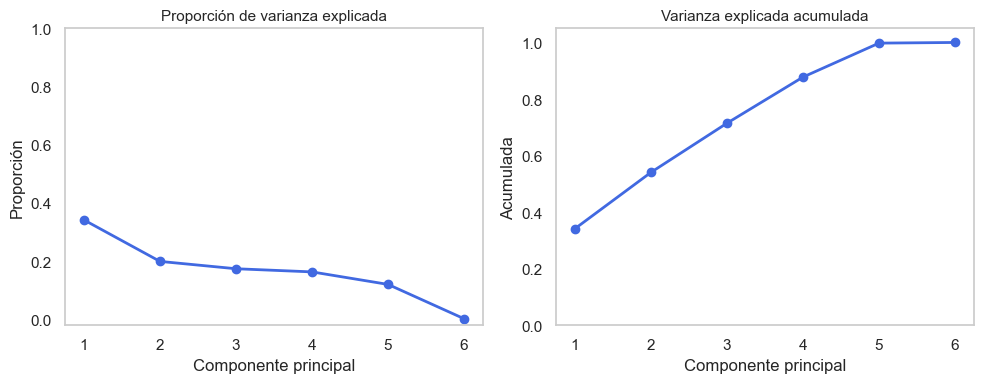

In [17]:
# === TP2 – PCA: Scree plots ===
import matplotlib.pyplot as plt
import numpy as np

ticks = np.arange(1, len(evr) + 1)

plt.figure(figsize=(10, 4))

# --- Panel 1: Proporción de varianza explicada ---
plt.subplot(1, 2, 1)
plt.plot(ticks, evr, marker='o', color='royalblue', linewidth=2)
plt.title("Proporción de varianza explicada", fontsize=11)
plt.xlabel("Componente principal")
plt.ylabel("Proporción")
plt.xticks(ticks)
plt.ylim(-0.02, 1)  # 🔧 margen inferior agregado
plt.grid(False)
plt.tick_params(axis='both', which='both', direction='out')

# --- Panel 2: Varianza explicada acumulada ---
plt.subplot(1, 2, 2)
plt.plot(ticks, evr_cum, marker='o', color='royalblue', linewidth=2)
plt.title("Varianza explicada acumulada", fontsize=11)
plt.xlabel("Componente principal")
plt.ylabel("Acumulada")
plt.xticks(ticks)
plt.ylim(0, 1.05)  # margen superior leve
plt.grid(False)
plt.tick_params(axis='both', which='both', direction='out')

plt.tight_layout()
plt.show()

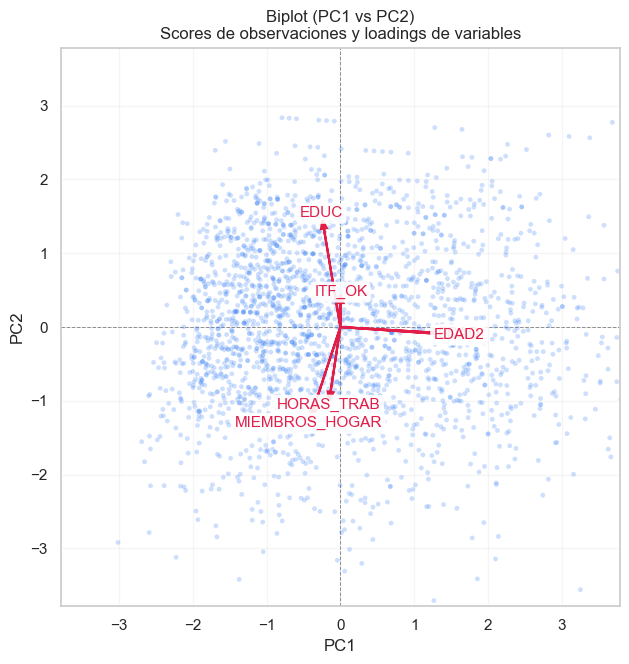

In [21]:
# === TP2 – PCA: BIPLOT (PC1 vs PC2) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# (1) Reconstruyo scores y loadings de forma segura
#    - pcs_df: DataFrame con columnas PC1, PC2, ...
#    - load_df: DataFrame con columnas PC1, PC2, ...
pcs_raw = pca.transform(X_scaled)                       # siempre existe
pcs_df  = (pd.DataFrame(pcs_raw, columns=[f"PC{i+1}" for i in range(pca.n_components_)])
           if not isinstance(pcs_raw, pd.DataFrame)
           else pcs_raw)

load_df = pd.DataFrame(
    pca.components_.T, index=X.columns,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)]
)

# (2) Tomo PC1 y PC2 como vectores numpy 
x_scores = pcs_df.iloc[:, 0].to_numpy()   # PC1
y_scores = pcs_df.iloc[:, 1].to_numpy()   # PC2

# (3) Parámetros de estética
point_color   = "#3b82f6"   # azul
arrow_color   = "#e11d48"   # rojo
point_alpha   = 0.25
point_size    = 12
arrow_scale   = 2.2
label_fontsz  = 11
title_fontsz  = 12

# (4) Figura
fig, ax = plt.subplots(1, 1, figsize=(6.8, 6.8))

# Puntos (scores)
ax.scatter(x_scores, y_scores, s=point_size, color=point_color,
           alpha=point_alpha, edgecolors="none", zorder=1)

# Ejes en 0
ax.axhline(0, color="gray", ls="--", lw=0.7, zorder=0)
ax.axvline(0, color="gray", ls="--", lw=0.7, zorder=0)

# Límites simétricos
lim = np.percentile(np.abs(np.column_stack([x_scores, y_scores])), 99) * 1.1
lim = max(lim, 1.2)
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)

# Flechas (loadings) y etiquetas
for var, row in load_df.iterrows():
    x = row["PC1"] * arrow_scale
    y = row["PC2"] * arrow_scale
    ax.arrow(0, 0, x, y, color=arrow_color, lw=1.6, length_includes_head=True,
             head_width=0.08*arrow_scale/2.2, head_length=0.12*arrow_scale/2.2, zorder=3)
    ax.text(x*1.06, y*1.06, var, fontsize=label_fontsz, color=arrow_color,
            ha="center", va="center",
            bbox=dict(boxstyle="round,pad=0.22", fc="white", ec="none", alpha=0.9),
            zorder=4)

# Aspecto y rótulos
ax.set_aspect('equal', adjustable='box')   # evita la advertencia y mantiene 1:1
ax.grid(True, alpha=0.18)
ax.set_xlabel("PC1"); ax.set_ylabel("PC2")
ax.set_title("Biplot (PC1 vs PC2)\nScores de observaciones y loadings de variables",
             fontsize=title_fontsz)

plt.tight_layout()
plt.show()


In [22]:
# === TP2 – CLUSTERING (K-MEANS) – Instalación y librerías ===
import sys, importlib, subprocess

# Verifica e instala librerías necesarias
def ensure(pkg):
    try:
        importlib.import_module(pkg)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", pkg])

for p in ["pandas", "numpy", "matplotlib", "seaborn", "scikit-learn"]:
    ensure(p)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [24]:
# === Preparación de datos (reutilizamos base del PCA) ===

# Variables a usar (las mismas del PCA)
vars_pca = ["EDAD", "EDAD2", "EDUC", "ITF_OK", "MIEMBROS_HOGAR", "HORAS_TRAB"]
X = base[vars_pca].dropna()

# Estandarizar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar PCA (2 componentes para clusterizar)
pca = PCA(n_components=2)
pcs = pca.fit_transform(X_scaled)

# DataFrame con los componentes
df_pca = pd.DataFrame(pcs, columns=["PC1", "PC2"])
df_pca.head()

,PC1,PC2
0,0.543775,1.066122
1,-0.022522,-0.004747
2,-0.406284,0.599621
3,-1.007165,0.557159
4,1.816814,1.669746


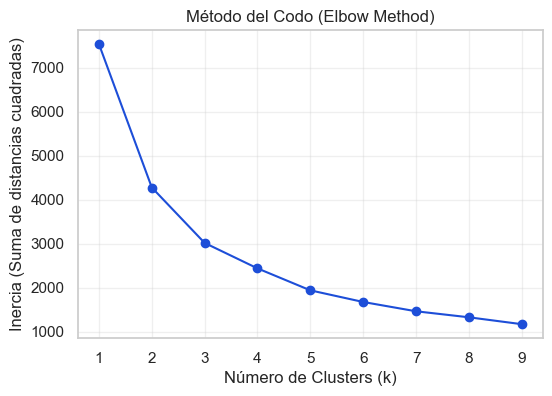

In [25]:
# === Método del Codo para elegir k ===
inertia = []
K = range(1, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_pca)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(K, inertia, 'o-', color="#1d4ed8")
plt.title("Método del Codo (Elbow Method)")
plt.xlabel("Número de Clusters (k)")
plt.ylabel("Inercia (Suma de distancias cuadradas)")
plt.grid(True, alpha=0.3)
plt.show()

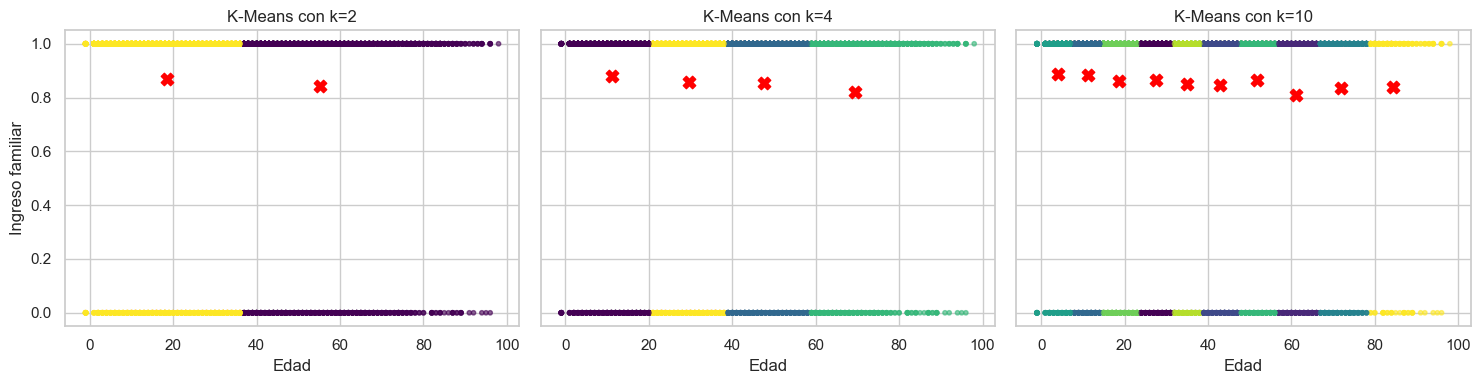

In [28]:
# === K-Means sobre variables originales: edad e ingreso ===
from sklearn.cluster import KMeans

X2 = base[["EDAD", "ITF_OK"]].dropna()

fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)  # 🔹 sharey=True evita repetir “Ingreso familiar”

for i, k in enumerate([2, 4, 10]):
    kmeans = KMeans(n_clusters=k, n_init=20, random_state=42)
    labels = kmeans.fit_predict(X2)
    axes[i].scatter(X2["EDAD"], X2["ITF_OK"], c=labels, cmap="viridis", s=10, alpha=0.6)
    axes[i].scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1],
                    c="red", marker="X", s=80)
    axes[i].set_title(f"K-Means con k={k}")
    axes[i].set_xlabel("Edad")
    if i == 0:
        axes[i].set_ylabel("Ingreso familiar")  # solo en el primer gráfico

plt.tight_layout()
plt.show()


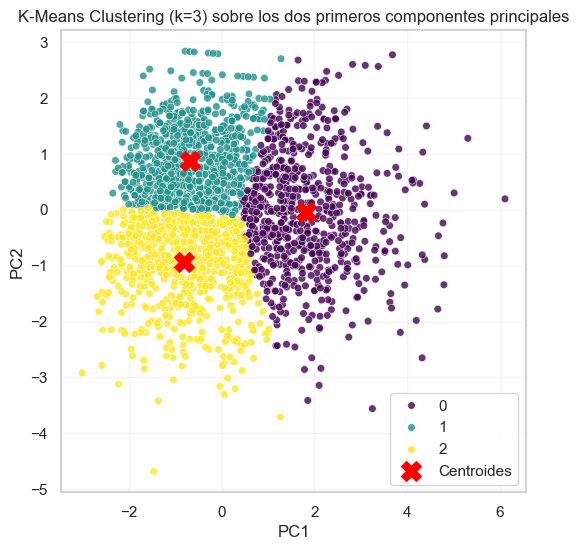

In [26]:
# === Aplicamos K-Means con el k óptimo ===
k_opt = 3  # Ajustá según el gráfico del codo

kmeans = KMeans(n_clusters=k_opt, random_state=42)
clusters = kmeans.fit_predict(df_pca)
df_pca["Cluster"] = clusters

# === Visualización ===
plt.figure(figsize=(6, 6))
sns.scatterplot(
    data=df_pca, x="PC1", y="PC2", hue="Cluster",
    palette="viridis", s=30, alpha=0.8
)
plt.scatter(
    kmeans.cluster_centers_[:, 0],
    kmeans.cluster_centers_[:, 1],
    s=200, c="red", marker="X", label="Centroides"
)
plt.title(f"K-Means Clustering (k={k_opt}) sobre los dos primeros componentes principales")
plt.legend()
plt.grid(alpha=0.2)
plt.show()